In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage.restoration import estimate_sigma
from skimage import measure, util
from skimage.io import imread, imsave

In [3]:
def clip(im):
    return np.maximum(0.,np.minimum(1.,im))

from os.path import normpath as fn # Fixes window/linux path conventions
import warnings
warnings.filterwarnings('ignore')

lena = np.float32(imread(fn('inputs/lena.jpg')))/255.
noisy_lena = np.float32(imread(fn('inputs/noisy_lena_.jpg')))/255.

In [5]:
# Gaussian Filtering
def gaussian(X,K):
    x, y = np.mgrid[-K:K + 1, -K:K + 1]
    g = np.exp(-(x ** 2 / float(K) + y ** 2 / float(K)))
    kern = g / g.sum()

    new_im = signal.convolve2d(X,kern,mode='same')
    return new_im

In [123]:
def wavelet(X,levels, lmain):
    def im2wv(img, nLev):
        # pyr array
        pyr = []
        h_mat = np.array([[1, 1, 1, 1],
                          [-1, 1, -1, 1],
                          [-1, -1, 1, 1],
                          [1, -1, -1, 1]])
        for i in range(nLev):
            n, mid = len(img), len(img) // 2
            # split image up for HWT
            a = img[:n:2, :n:2]
            b = img[1:n:2, :n:2]
            c = img[:n:2, 1:n:2]
            d = img[1:n:2, 1:n:2]
            vec = np.array([a, b, c, d])
            # reshape vector to perform mat mult
            D = 1 / 2 * np.dot(h_mat, vec.reshape(4, mid * mid))
            L, H1, H2, H3 = D.reshape([4, mid, mid])
            pyr.append([H1, H2, H3])
            img = L
        pyr.append(L)
        return pyr

    def wv2im(pyr):
        # need inverse of unitary matrix
        h_mat = np.array([[1, 1, 1, 1],
                          [-1, 1, -1, 1],
                          [-1, -1, 1, 1],
                          [1, -1, -1, 1]])
        h_mat_inv = np.linalg.inv(h_mat)
        # last spot in pyramid is small img
        # iterate in reverse to reconstruct
        L = pyr[-1]
        for [H1, H2, H3] in reversed(pyr[:-1]):
            n, n2 = len(L), len(L) * 2
            vec = np.array([L, H1, H2, H3])
            # reshape vector to perform mat mult
            D = 2 * np.dot(h_mat_inv, vec.reshape(4, n * n))
            a, b, c, d = D.reshape([4, n, n])
            # assign pixels to correct spots in img
            img = np.empty((n2, n2))
            img[:n2:2, :n2:2] = a
            img[1:n2:2, :n2:2] = b
            img[:n2:2, 1:n2:2] = c
            img[1:n2:2, 1:n2:2] = d
            L = img
        return L

    # Return corresponding coefficients x (same shape/size)
    # that minimizes (x - y)^2 + lmbda * abs(x)
    def denoise_coeff(y, lmbda):
        x = np.copy(y)
        x[np.where(y > lmbda / 2.0)] -= lmbda / 2.0
        x[np.where(y < -lmbda / 2.0)] += lmbda / 2.0
        x[np.where(np.logical_and(y>-lmbda/2.0,y<lmbda/2.0))] = 0

        return x

    pyr = im2wv(X, levels)
    for i in range(len(pyr) - 1):
        for j in range(2):
            pyr[i][j] = denoise_coeff(pyr[i][j], lmain / (2 ** i))
        pyr[i][2] = denoise_coeff(pyr[i][2], np.sqrt(2) * lmain / (2 ** i))

    im = wv2im(pyr)
    return im

In [106]:
def bfilt(X,K,sgm_s,sgm_i):
    Xpad =np.pad(X,K,'constant',constant_values=0)
    nx, ny = X.shape
    yy = np.zeros(X.shape)
    B = np.zeros(X.shape)

    for i in range(-K, K + 1):
        for j in range(-K, K + 1):
            idx_sq = i ** 2 + j ** 2
            X_sq = np.square(Xpad[K + i:nx + (K + i), K + j:ny + (K + j)] - Xpad[K:(nx + K), K:(ny + K)])
            ss = idx_sq / (2 * sgm_s ** 2)
            si = X_sq / (2 * sgm_i ** 2)
            ex = np.exp(-si - ss)
            B += ex
            yy += ex * Xpad[K + i:nx + (K + i), K + j:ny + (K + j)]
            
    return yy / B

In [81]:
def nlm(X, N, K, sigma):
    H, W = X.shape
    pad_len = N+K
    Xpad=np.pad(X,pad_len,'constant',constant_values=0)

    yy = np.zeros(X.shape)
    B = np.zeros([H, W])

    for ny in range(-N, N + 1):
        for nx in range(-N, N + 1):
            # compute neighborhood SSD by looping through kernel
            # array to hold values to calculate SSD
            ssd = np.zeros((H,W))
            for ky in range(-K, K + 1):
                for kx in range(-K, K + 1):
                    ssd += np.square(
                        Xpad[pad_len+ny+ky:H+pad_len+ny+ky,pad_len+nx+kx:W+pad_len+nx+kx]
                        - Xpad[pad_len+ky:H+pad_len+ky,pad_len+kx:W+pad_len+kx])
            # compute SSD for these set of neighborhood pixels
            ex = np.exp(-ssd/(2*sigma**2))
            B += ex
            yy += ex * Xpad[pad_len+ny:H+pad_len+ny,pad_len+nx:W+pad_len+nx]

    return yy / B

In [163]:
print("NLM...")
nlm_lena = nlm(noisy_lena,10,4,0.6)
nlm_psnr = measure.compare_psnr(lena, nlm_lena)
nlm_psnr

NLM...


29.41454458345513

In [117]:
print("BLF...")
blf_lena = bfilt(noisy_lena,5,1,10)
blf_psnr = measure.compare_psnr(lena, blf_lena)
blf_psnr

BLF...


28.448938618420495

In [120]:
print("Gaussian...")
gaussian_lena = gaussian(noisy_lena,5)
gaussian_psnr = measure.compare_psnr(lena, gaussian_lena)
gaussian_psnr

Gaussian...


27.762614820941096

In [124]:
print("Wavelet...")
wav_lena = wavelet(noisy_lena,5,0.5)
wav_psnr = measure.compare_psnr(lena, wav_lena)
wav_psnr

Wavelet...


27.91833723833108

In [125]:
lena_psnr = measure.compare_psnr(lena, lena)
noisy_psnr = measure.compare_psnr(lena, noisy_lena)
nlm_psnr = measure.compare_psnr(lena, nlm_lena)
blf_psnr = measure.compare_psnr(lena, blf_lena)
gaussian_psnr = measure.compare_psnr(lena, gaussian_lena)
wav_psnr = measure.compare_psnr(lena, wav_lena)

print("Noisy",noisy_psnr)
print("NLM Denoised",nlm_psnr)
print("BLF Denoised",blf_psnr)
print("Gaussian Denoised",gaussian_psnr)
print("Wavelet Denoised",wav_psnr)

Noisy 19.52515735883194
NLM Denoised 29.545095190477205
BLF Denoised 28.448938618420495
Gaussian Denoised 27.762614820941096
Wavelet Denoised 27.91833723833108


In [132]:
lena_mse = measure.compare_mse(lena, lena)
noisy_mse = measure.compare_mse(lena, noisy_lena)
nlm_mse = measure.compare_mse(lena, nlm_lena)
blf_mse = measure.compare_mse(lena, blf_lena)
gaussian_mse = measure.compare_mse(lena, gaussian_lena)
wav_mse = measure.compare_mse(lena, wav_lena)

print("Noisy",noisy_mse)
print("NLM Denoised",nlm_mse)
print("BLF Denoised",blf_mse)
print("Gaussian Denoised",gaussian_mse)
print("Wavelet Denoised",wav_mse)

Noisy 0.011155377311056293
NLM Denoised 0.0011104281962382272
BLF Denoised 0.0014292432116394982
Gaussian Denoised 0.0016739347219544066
Wavelet Denoised 0.0016149767565887888


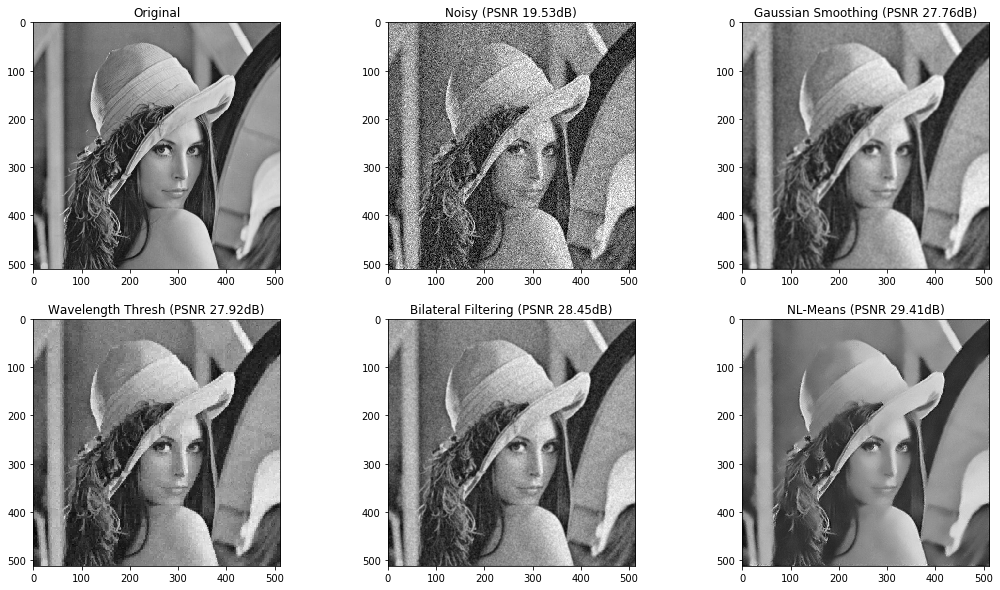

In [164]:
plt.figure(figsize=(18,10))

images = [lena,noisy_lena,gaussian_lena,wav_lena,blf_lena,nlm_lena]
titles = ["Original","Noisy","Gaussian Smoothing","Wavelength Thresh","Bilateral Filtering", "NL-Means"]

plt.subplot(2,3,1)
plt.imshow(lena,cmap='gray')
plt.title("Original")
for i in range(len(images)-1):
    plt.subplot(2,3,i+2)
    title = titles[i+1] + " (PSNR {0:.2f}dB)".format(measure.compare_psnr(lena, images[i+1]))
    plt.title(title)
    plt.imshow(images[i+1],cmap='gray')
